# 工作流程
* 載入需要的套件
* 從COCO的驗證資料集中找一張範例照片，並且網上下載，顯示照片
* 進行物件偵測，做方框標記
* 列出偵測出來的類別代碼，以及方框座標
* 列出代碼對應的物件
* 顯示辨識出來的圖形
* 展示骨骼標記
* 展示全景分割

In [ ]:
# install dependencies: 
!pip install pyyaml==5.1 pycocotools>=2.0.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.6)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
assert torch.__version__.startswith("1.6")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

In [1]:
import detectron2
import cv2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from matplotlib import pyplot as plt

--2020-10-11 14:17:06--  http://images.cocodataset.org/val2017/000000398742.jpg
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.242.12
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.242.12|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 166677 (163K) [image/jpeg]
Saving to: ‘input.jpg’

input.jpg           100%[===================>] 162.77K   627KB/s    in 0.3s    

2020-10-11 14:17:07 (627 KB/s) - ‘input.jpg’ saved [166677/166677]



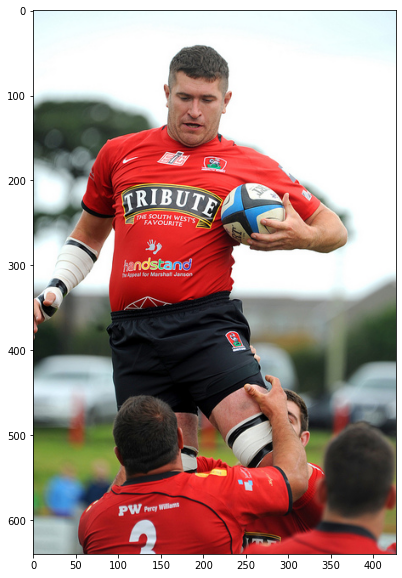

In [2]:
!wget http://images.cocodataset.org/val2017/000000398742.jpg -O input.jpg
im = cv2.imread("./input.jpg")
plt.figure(figsize=(20,10))
plt.imshow(im[:,:,::-1])

# 程式流程
* 宣告設定檔物件
* 取得設定檔，指定需要的模型種類
* 設定辨識值的門檻
* 下載模型
* 宣告偵測器，並且進行偵測
* 展示類別代碼及標記值
* 利用內建Visualizer將偵測出的圖形顯示出來

In [3]:
# Inference with a object detection model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")

# If your detectron2's version is not the most updated, please use direct link as followed, to get the link , please visit 
# https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md

# cfg.MODEL.WEIGHTS = "https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl"

predictor = DefaultPredictor(cfg)
outputs = predictor(im)


model_final_280758.pkl: 167MB [00:15, 10.7MB/s]                           
/usr/local/lib/python3.6/dist-packages/detectron2/layers/wrappers.py:226: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  return x.nonzero().unbind(1)


In [4]:
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([32,  0,  0,  2,  0,  2, 67,  0], device='cuda:0')
Boxes(tensor([[2.2044e+02, 2.0393e+02, 2.9830e+02, 2.7207e+02],
        [9.9253e+00, 3.2720e+01, 3.6502e+02, 5.8540e+02],
        [2.7347e+02, 4.8053e+02, 4.2596e+02, 6.3842e+02],
        [3.6393e-01, 4.0535e+02, 9.8682e+01, 4.9059e+02],
        [5.6441e+01, 4.5099e+02, 3.5142e+02, 6.3683e+02],
        [3.4890e+02, 4.1373e+02, 4.2687e+02, 4.9946e+02],
        [2.4835e+02, 6.1426e+02, 2.9192e+02, 6.3030e+02],
        [5.6333e+01, 5.2738e+02, 8.9921e+01, 5.8384e+02]], device='cuda:0'))


In [5]:
all_things = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes
preds = [all_things[x] for x in outputs["instances"].pred_classes]
preds

['sports ball',
 'person',
 'person',
 'car',
 'person',
 'car',
 'cell phone',
 'person']

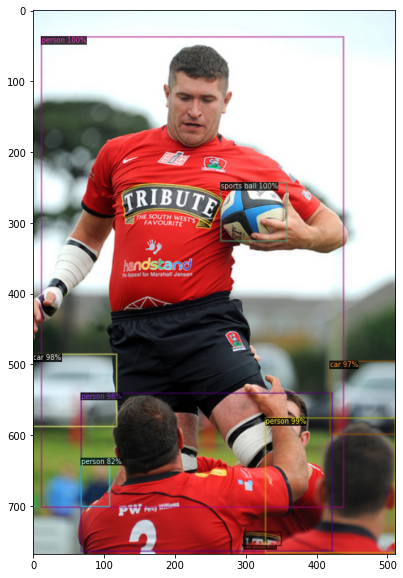

In [6]:
v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(20,10))
plt.imshow(v.get_image())

['person', 'sports ball', 'person', 'person', 'car', 'car', 'person', 'person', 'cell phone']


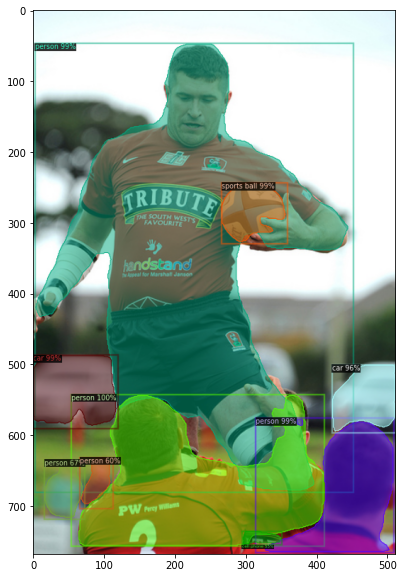

In [11]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
#cfg.MODEL.WEIGHTS = './model_final_f10217.pkl'
predictor = DefaultPredictor(cfg)
all_things = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes
preds = [all_things[x] for x in outputs["instances"].pred_classes]
print(preds)
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(20,10))
plt.imshow(v.get_image())

model_final_a6e10b.pkl: 237MB [00:21, 11.1MB/s]                           


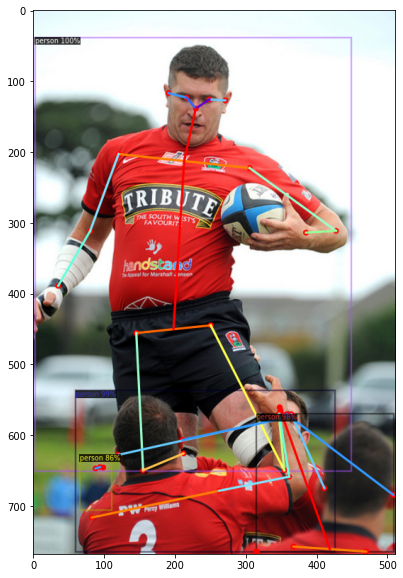

In [8]:
# Inference with a keypoint detection model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)
v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(20,10))
plt.imshow(v.get_image())

model_final_cafdb1.pkl: 261MB [00:23, 11.3MB/s]                           


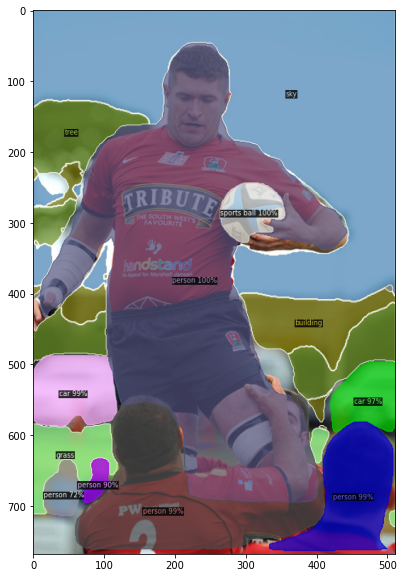

In [9]:
# Inference with a panoptic segmentation model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor = DefaultPredictor(cfg)
panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
plt.figure(figsize=(20,10))
plt.imshow(v.get_image())